# Problema 1
Calcule las frecuencias naturales de oscilación transversal de una barra de acero (densidad 7850 kg/m3 y módulo de elasticidad E = 210 GPa), de 1 m de longitud, 10 cm2
 de área, momento de inercia de 10 cm4. Realice el cálculo para un número variable de elementos y estudie la convergencia de sus resultados. Haga el cálculo para matrices de masa concentrada y consistente. Grafique los desplazamientos en función de la posición para los primeros modos normales.


In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

    
GL = 2          # Grados de libertad
E = 210e9       # GPa Modulo de elasticidad
dens = 7850     # kg/m3 densidad
I = 10e-8       # cm4 Momento de inercia
Ltot = 1        # cm Longitud total de la barra
A = 10e-4       # cm2 

Cálculo los autovalores y autovectores de la siguiente ecuación:


$ (\hspace{0.5mm}[K]   -  \omega^2 \hspace{1mm}  [M]\hspace{0.5mm})\hspace{2mm} \{u\} = 0 $

In [25]:
from scipy.linalg import eigh

e = 100        # Cantidad de elementos → Cantidad de nodos = e+1

def modos(e, matriz, show="False"):
    '''e: Cantidad de elementos
       matriz:  concentrada (= Cc) o consistente (= Cs) '''
    Nx = np.linspace(0,Ltot,e+1)         # Posiciones de equilibrio de los nodos en x
    N = len(Nx)
    L = Nx[1]-Nx[0]                      # Longitud de cada elemento

    s = [0,1]                            # Primer elemento empotrado en X e Y
    r = np.delete(np.arange(N*2), s)

    M = np.zeros((GL*N,GL*N))            # Matriz masa concentrada

    K = M.copy()                         # Matriz de rigidez global

    if matriz== "Cs":
        Mc= (1/420) * np.array([[156, 22*L, 54, -13*L],
                             [22*L, 4*L**2, 13*L, -3*L**2],
                             [54, 13*L, 156, -22*L],
                             [-13*L, -3*L**2, -22*L, 4*L**2]])
    else: 
        m=np.zeros((4,4))                 # Matriz masa 
        m[0,0]=12
        m[1,1]=L**2
        m[2,2]=12
        m[3,3]=L**2
        Mc= m/24
            
    for i in range(e):
        n1=i*2
        n2=i*2+4
        M[n1:n2,n1:n2]+= (dens*A*L)  * Mc
        KL=(E*I)/(L**3)* np.array( [[12, 6*L, -12, 6*L], 
                      [6*L, 4*(L**2), -6*L, 2*(L**2)],
                      [-12, -6*L, 12, -6*L], 
                      [6*L, 2*(L**2), -6*L, 4*(L**2)]])
        K[2*i:2*i+GL*2, 2*i:2*i+GL*2]+= KL

    w, av = eigh(K[np.ix_(r,r)],M[np.ix_(r,r)])       # Autovalores w, Autovectores av

    # Elimino los ángulos de los autovectores  (los elementos con index impar)
    Av = av.copy()                                    # Auxiliar para graficar con interpolaciones
    Av=Av/Av[-2,:]
    Av=np.vstack([np.zeros(e*2),np.zeros(e*2) , Av])  # Agrego el primer nodo
    av = av[::2]                                      # Elimino columnas impares
    av=av/av[-1]                # Normalizo respecto al último elemento del autovector (desplazamiento del último nodo)
    av=np.vstack([np.zeros(e*2), av])                 # Agrego el primer nodo

    if show=="True":
        return(Nx, av, np.sqrt(w[0:3])/(2*np.pi), Av)
    return(np.sqrt(w[0:3])/(2*np.pi))


#### Gráfico directo

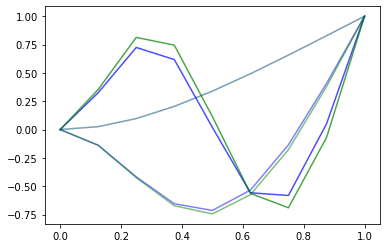

In [26]:
Nx, avCs, w , aV= modos (8, "Cs", "True")
Nx, avCc, w , aV= modos (8, "Cc", "True")
a=0
for i in range(3):
    plt.plot(Nx, avCs[:,i], "b", alpha=0.3+a)
    plt.plot(Nx, avCc[:,i], "g", alpha=0.3+a)
    a+=0.2

### Estudio de convergencia de ambos métodos

(2.0, 40.0)

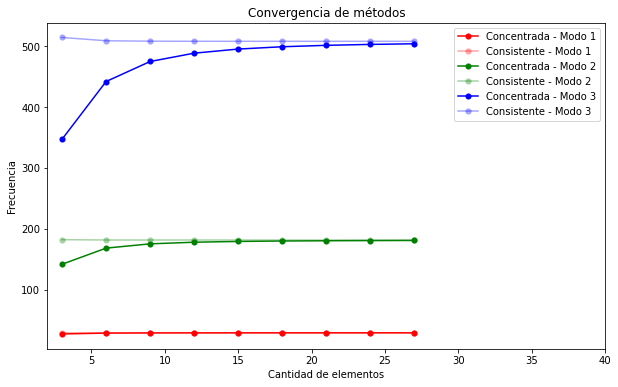

In [27]:

e = 30
Wcc = []                          # Frecuencias iniciales calculadas con la matriz concentrada
Wcs = []                          # Frecuencias iniciales calculadas con la matriz consistente
NE = []                           # Números de elementos 
for i in range(3,e,3):
    Wcc.append(modos(i, "Cc"))
    Wcs.append(modos(i, "Cs"))
    NE.append(i)

color=["r", "g", "b"]
plt.figure(figsize=(10,6))
for i in range(3):
    plt.plot(NE, np.array(Wcc)[:,i], "o-"+color[i], markeredgewidth=0.1, label=f"Concentrada - Modo {i+1}")
    plt.plot(NE, np.array(Wcs)[:,i], "o-"+color[i],alpha=0.35,  markeredgewidth=0.1, label=f"Consistente - Modo {i+1}")
plt.legend(loc="upper right")
plt.title("Convergencia de métodos")
plt.xlabel("Cantidad de elementos")
plt.ylabel("Frecuencia")
plt.xlim(2,40)

### Gráfico mediante interpolación

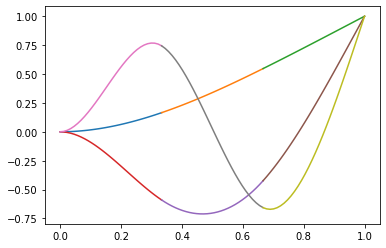

In [41]:
v = lambda a1, a2, a3, a4, x: a1*x**3 + a2*x**2 + a3*x + a4

e=3
Nx, AV, w , av = modos (e, "Cs", "True")

for j in range(3):
    V=av[:,j]
    for i in range(e):
        L=Nx[i+1]-Nx[i]
        a1 = 2/L**3 * (V[2*i] - V[2*i+2]) + 1/L**2 * (V[2*i+1] + V[2*i+3])
        a2 = -(3/L**2)*(V[2*i] - V[2*i+2]) - 1/L * (2*V[2*i+1] + V[2*i+3])
        a3 = V[2*i+1]
        a4 = V[2*i]
        x = np.linspace(Nx[i], Nx[i+1],30)
        plt.plot(x, v(a1, a2, a3, a4, np.linspace(0, L, 30)))

### 

**Fin**

--**_Aguante física_**--